# xRFI explorative tests

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib notebook

import matplotlib.pyplot as plt

from edges_cal import xrfi

In [2]:
NFREQ = 1000
freq = np.linspace(50, 150, NFREQ)

In [3]:
p = np.poly1d([1750, 0, 3, -2, 7, 5][::-1])
f = np.linspace(-1, 1, len(freq))
sky_model = (freq / 75.0) ** -2.55 * p(f)

In [11]:
rfi_model = np.zeros(NFREQ)
# rfi_model[::50] = 1

In [5]:
def thermal_noise(spec, scale=1, seed=None):
    if seed:
        np.random.seed(seed)
    return np.random.normal(0, spec / scale)

In [6]:
scale = 1000
amplitude = 50

In [12]:
std = sky_model/scale
amp = std.max() * amplitude
noise = thermal_noise(sky_model, scale=scale, seed=1010)
rfi = rfi_model * amp
sky = sky_model + noise + rfi

<IPython.core.display.Javascript object>


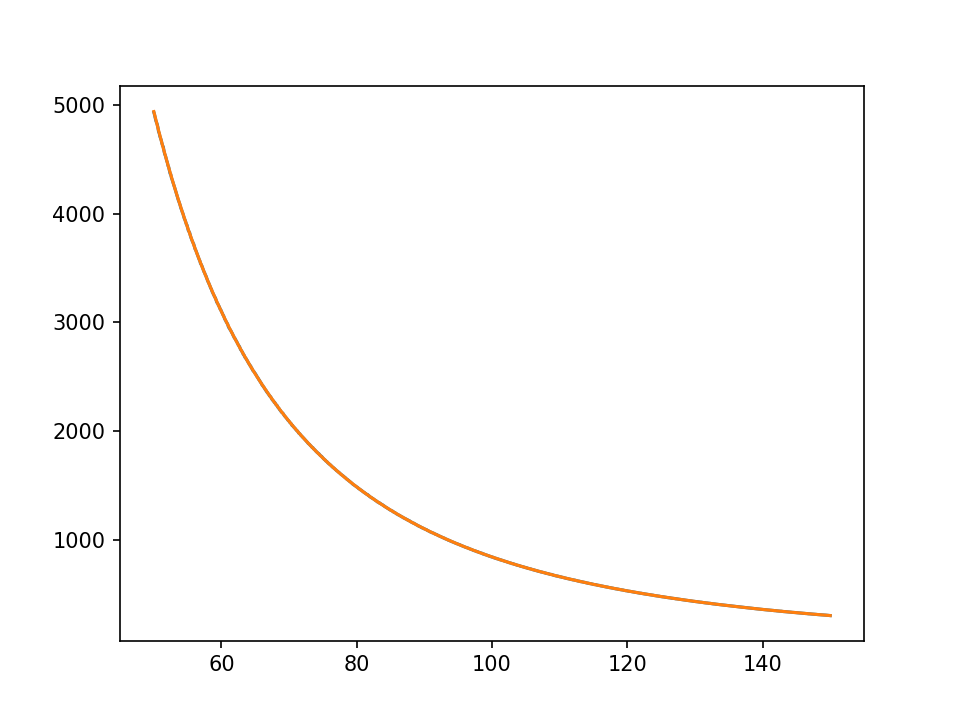

In [22]:
plt.plot(freq, sky)
plt.plot(freq, sky_model)

In [33]:
sig = xrfi.detrend_medfilt(sky, half_size=(8,))

(17,)


In [36]:
from scipy.signal import medfilt

In [84]:
f = np.linspace(0, 1, len(sky))
resid = sky - xrfi.ModelFit('polynomial', f, sky, n_terms=3).evaluate()

Polynomial


<IPython.core.display.Javascript object>


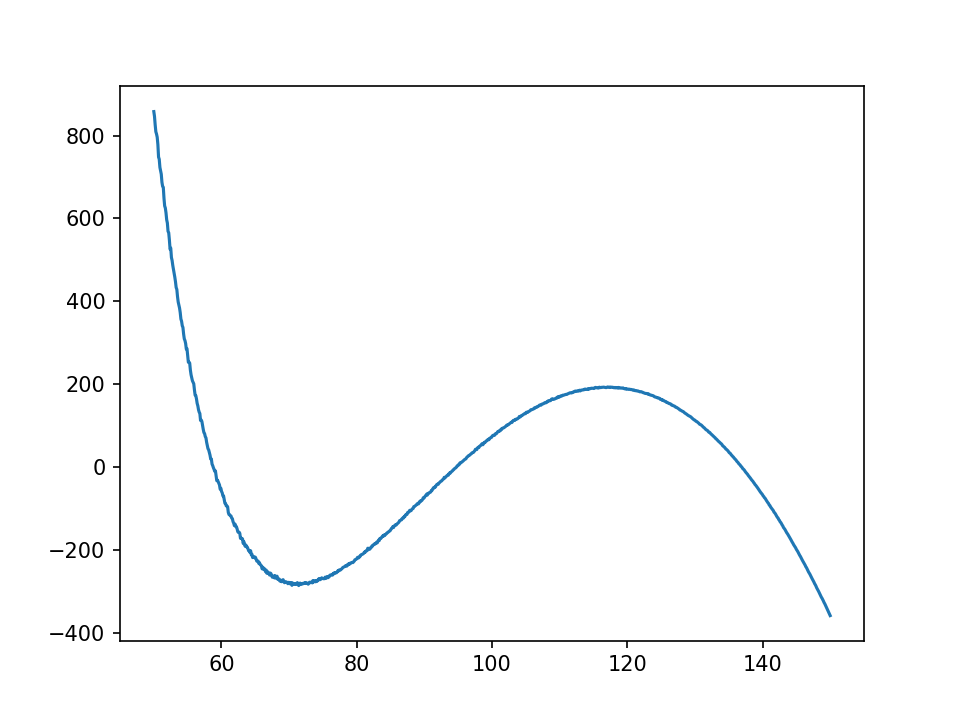

In [85]:
plt.plot(freq, resid)

In [86]:
size=5
d_sm = xrfi.flagged_median_filter(resid, size=(size,))
d_rs = sky - d_sm
d_sq = d_rs ** 2
sigma = np.sqrt(xrfi.flagged_median_filter(d_sq, size=(size,)) / 0.456)
significance = xrfi.robust_divide(d_rs, sigma)
flags = np.abs(significance) > 10

<IPython.core.display.Javascript object>


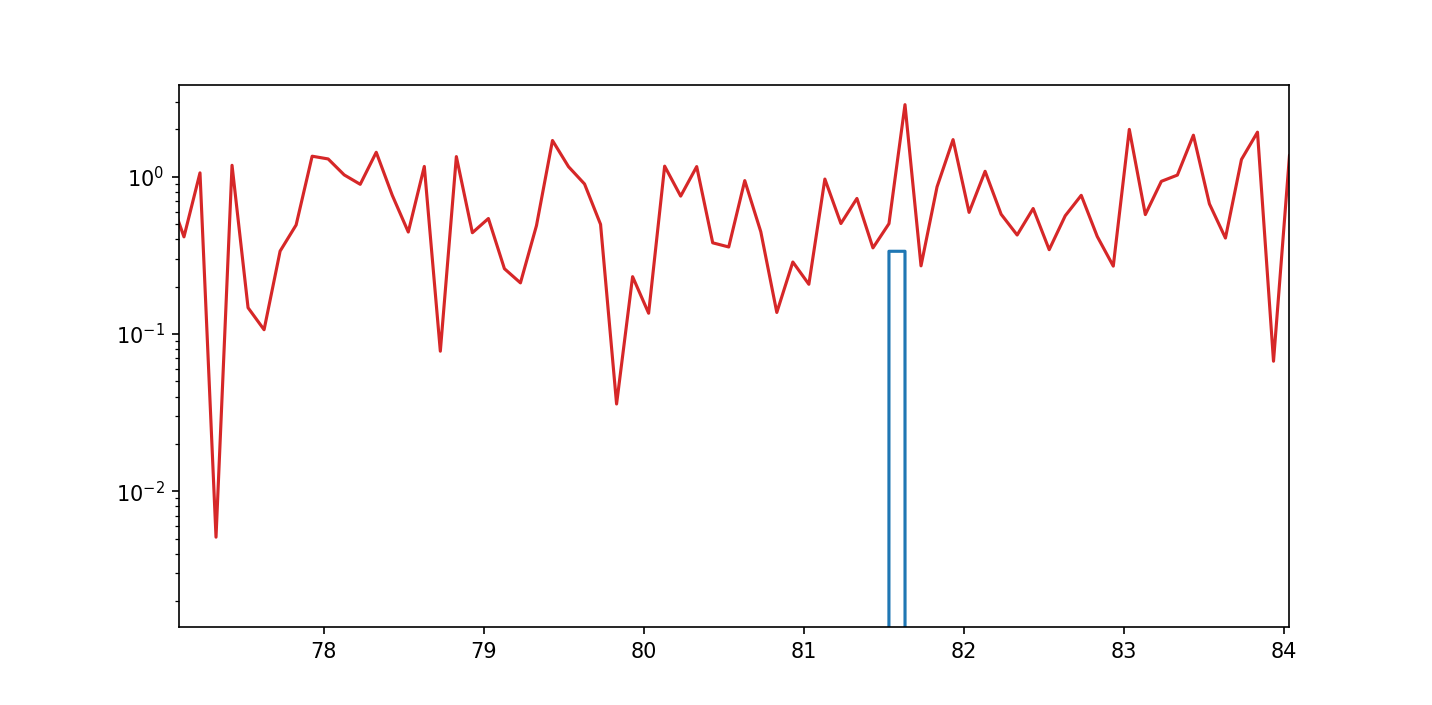

In [67]:
plt.plot(freq, np.abs(d_rs))
plt.plot(freq, sigma)
plt.plot(freq, significance)
plt.plot(freq, np.abs((sky - sky_model)) / std)
plt.yscale('log')

In [87]:
np.any(flags), np.where(flags)[0]

(False, array([], dtype=int64))

In [72]:
d_rs[313:319]

array([ 0.        ,  0.        , -0.33549046,  0.33549046,  0.        ,
        0.        ])

In [64]:
flags, sig = xrfi.xrfi_medfilt(sky, kf=1)

(3,)


In [65]:
np.any(flags)

False

In [21]:
np.where(flags)

(array([  0,   1,   2,   3, 315, 316, 374, 375, 512, 513, 549, 550, 586,
        587, 595, 596, 641, 642, 651, 652, 657, 658, 685, 686, 697, 698,
        730, 731, 743, 744, 751, 752, 757, 758, 765, 766, 771, 772, 801,
        802, 820, 821, 845, 846, 850, 851, 870, 871, 900, 901, 902, 903,
        909, 910, 916, 918, 921, 922, 923, 924, 925, 926, 935, 936, 963,
        964, 967, 968, 976, 977, 986, 987, 990, 991, 992, 993, 994, 995,
        997, 998, 999]),)